<a href="https://colab.research.google.com/github/AmlanSamanta/TensorFlow_Examples/blob/main/MNISTDigitsConvNNClassifier_KerasTensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Parameters and Imports

In [1]:
BATCH_SIZE = 128
EPOCHS = 10

# MNIST dataset is sourced from the files hosted on a public GCS bucket
training_images_file   = 'gs://mnist-public/train-images-idx3-ubyte'
training_labels_file   = 'gs://mnist-public/train-labels-idx1-ubyte'
validation_images_file = 'gs://mnist-public/t10k-images-idx3-ubyte'
validation_labels_file = 'gs://mnist-public/t10k-labels-idx1-ubyte'

import os, re, math, json, shutil, pprint
import PIL.Image, PIL.ImageFont, PIL.ImageDraw
import IPython.display as display
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
print("Tensorflow version " + tf.__version__)

Tensorflow version 2.9.2


##Utility methods

In [2]:
# Matplotlib config
plt.ioff()
plt.rc('image', cmap='gray_r')
plt.rc('grid', linewidth=1)
plt.rc('xtick', top=False, bottom=False, labelsize='large')
plt.rc('ytick', left=False, right=False, labelsize='large')
plt.rc('axes', facecolor='F8F8F8', titlesize="large", edgecolor='white')
plt.rc('text', color='a8151a')
plt.rc('figure', facecolor='F0F0F0', figsize=(16,9))
# Matplotlib fonts
MATPLOTLIB_FONT_DIR = os.path.join(os.path.dirname(plt.__file__), "mpl-data/fonts/ttf")

# pull a batch from the datasets. 
def dataset_to_numpy_util(training_dataset, validation_dataset, N):
  
  # get one batch from each: 10000 validation digits, N training digits
  batch_train_ds = training_dataset.unbatch().batch(N)
  
  # eager execution: loop through datasets normally
  if tf.executing_eagerly():
    for validation_digits, validation_labels in validation_dataset:
      validation_digits = validation_digits.numpy()
      validation_labels = validation_labels.numpy()
      break
    for training_digits, training_labels in batch_train_ds:
      training_digits = training_digits.numpy()
      training_labels = training_labels.numpy()
      break
    
  else:
    v_images, v_labels = validation_dataset.make_one_shot_iterator().get_next()
    t_images, t_labels = batch_train_ds.make_one_shot_iterator().get_next()
    # Run once, get one batch. Session.run returns numpy results
    with tf.Session() as ses:
      (validation_digits, validation_labels,
       training_digits, training_labels) = ses.run([v_images, v_labels, t_images, t_labels])
  
  # these were one-hot encoded in the dataset
  validation_labels = np.argmax(validation_labels, axis=1)
  training_labels = np.argmax(training_labels, axis=1)
  
  return (training_digits, training_labels,
          validation_digits, validation_labels)

# create digits from local fonts for testing
def create_digits_from_local_fonts(n):
  font_labels = []
  img = PIL.Image.new('LA', (28*n, 28), color = (0,255)) # format 'LA': black in channel 0, alpha in channel 1
  font1 = PIL.ImageFont.truetype(os.path.join(MATPLOTLIB_FONT_DIR, 'DejaVuSansMono-Oblique.ttf'), 25)
  font2 = PIL.ImageFont.truetype(os.path.join(MATPLOTLIB_FONT_DIR, 'STIXGeneral.ttf'), 25)
  d = PIL.ImageDraw.Draw(img)
  for i in range(n):
    font_labels.append(i%10)
    d.text((7+i*28,0 if i<10 else -4), str(i%10), fill=(255,255), font=font1 if i<10 else font2)
  font_digits = np.array(img.getdata(), np.float32)[:,0] / 255.0 # black in channel 0, alpha in channel 1 (discarded)
  font_digits = np.reshape(np.stack(np.split(np.reshape(font_digits, [28, 28*n]), n, axis=1), axis=0), [n, 28*28])
  return font_digits, font_labels

# utility to display a row of digits with their predictions
def display_digits(digits, predictions, labels, title, n):
  fig = plt.figure(figsize=(13,3))
  digits = np.reshape(digits, [n, 28, 28])
  digits = np.swapaxes(digits, 0, 1)
  digits = np.reshape(digits, [28, 28*n])
  plt.yticks([])
  plt.xticks([28*x+14 for x in range(n)], predictions)
  plt.grid(b=None)
  for i,t in enumerate(plt.gca().xaxis.get_ticklabels()):
    if predictions[i] != labels[i]: t.set_color('red') # bad predictions in red
  plt.imshow(digits)
  plt.grid(None)
  plt.title(title)
  display.display(fig)
  
# utility to display multiple rows of digits, sorted by unrecognized/recognized status
def display_top_unrecognized(digits, predictions, labels, n, lines):
  idx = np.argsort(predictions==labels) # sort order: unrecognized first
  for i in range(lines):
    display_digits(digits[idx][i*n:(i+1)*n], predictions[idx][i*n:(i+1)*n], labels[idx][i*n:(i+1)*n],
                   "{} sample validation digits out of {} with bad predictions in red and sorted first".format(n*lines, len(digits)) if i==0 else "", n)

def plot_learning_rate(lr_func, epochs):
  xx = np.arange(epochs+1, dtype=np.float)
  y = [lr_decay(x) for x in xx]
  fig, ax = plt.subplots(figsize=(9, 6))
  ax.set_xlabel('epochs')
  ax.set_title('Learning rate\ndecays from {:0.3g} to {:0.3g}'.format(y[0], y[-2]))
  ax.minorticks_on()
  ax.grid(True, which='major', axis='both', linestyle='-', linewidth=1)
  ax.grid(True, which='minor', axis='both', linestyle=':', linewidth=0.5)
  ax.step(xx,y, linewidth=3, where='post')
  display.display(fig)

class PlotTraining(tf.keras.callbacks.Callback):
  def __init__(self, sample_rate=1, zoom=1):
    self.sample_rate = sample_rate
    self.step = 0
    self.zoom = zoom
    self.steps_per_epoch = 60000//BATCH_SIZE

  def on_train_begin(self, logs={}):
    self.batch_history = {}
    self.batch_step = []
    self.epoch_history = {}
    self.epoch_step = []
    self.fig, self.axes = plt.subplots(1, 2, figsize=(16, 7))
    plt.ioff()

  def on_batch_end(self, batch, logs={}):
    if (batch % self.sample_rate) == 0:
      self.batch_step.append(self.step)
      for k,v in logs.items():
        # do not log "batch" and "size" metrics that do not change
        # do not log training accuracy "acc"
        if k=='batch' or k=='size':# or k=='acc':
          continue
        self.batch_history.setdefault(k, []).append(v)
    self.step += 1

  def on_epoch_end(self, epoch, logs={}):
    plt.close(self.fig)
    self.axes[0].cla()
    self.axes[1].cla()
      
    self.axes[0].set_ylim(0, 1.2/self.zoom)
    self.axes[1].set_ylim(1-1/self.zoom/2, 1+0.1/self.zoom/2)
    
    self.epoch_step.append(self.step)
    for k,v in logs.items():
      # only log validation metrics
      if not k.startswith('val_'):
        continue
      self.epoch_history.setdefault(k, []).append(v)

    display.clear_output(wait=True)
    
    for k,v in self.batch_history.items():
      self.axes[0 if k.endswith('loss') else 1].plot(np.array(self.batch_step) / self.steps_per_epoch, v, label=k)
      
    for k,v in self.epoch_history.items():
      self.axes[0 if k.endswith('loss') else 1].plot(np.array(self.epoch_step) / self.steps_per_epoch, v, label=k, linewidth=3)
      
    self.axes[0].legend()
    self.axes[1].legend()
    self.axes[0].set_xlabel('epochs')
    self.axes[1].set_xlabel('epochs')
    self.axes[0].minorticks_on()
    self.axes[0].grid(True, which='major', axis='both', linestyle='-', linewidth=1)
    self.axes[0].grid(True, which='minor', axis='both', linestyle=':', linewidth=0.5)
    self.axes[1].minorticks_on()
    self.axes[1].grid(True, which='major', axis='both', linestyle='-', linewidth=1)
    self.axes[1].grid(True, which='minor', axis='both', linestyle=':', linewidth=0.5)
    display.display(self.fig)

##Parse data files and prepare training and validation datasets

In [3]:
AUTO = tf.data.experimental.AUTOTUNE

def read_label(tf_bytestring):
    label = tf.io.decode_raw(tf_bytestring, tf.uint8)
    label = tf.reshape(label, [])
    label = tf.one_hot(label, 10)
    return label
  
def read_image(tf_bytestring):
    image = tf.io.decode_raw(tf_bytestring, tf.uint8) # the imagebyte data is decoded into images
    image = tf.cast(image, tf.float32)/256.0 # image conversion in floating point values between 0 and 1
    image = tf.reshape(image, [28*28]) # reshape it as flat array of pixels size 28*28 expected by the dense layer
    return image
  
def load_dataset(image_file, label_file):
    # dedicated fixed record function of tf.data API is used to load the dataset in image bytes
    imagedataset = tf.data.FixedLengthRecordDataset(image_file, 28*28, header_bytes=16)
    imagedataset = imagedataset.map(read_image, num_parallel_calls=16) # applying the function using map
    labelsdataset = tf.data.FixedLengthRecordDataset(label_file, 1, header_bytes=8)
    labelsdataset = labelsdataset.map(read_label, num_parallel_calls=16)
    dataset = tf.data.Dataset.zip((imagedataset, labelsdataset)) # dataset of pairs (image, label)
    return dataset 
  
def get_training_dataset(image_file, label_file, batch_size):
    dataset = load_dataset(image_file, label_file)
    dataset = dataset.cache()  # this small dataset can be entirely cached in RAM, for TPU this is important to get good performance from such a small dataset
    dataset = dataset.shuffle(5000, reshuffle_each_iteration=True) # shuffles it with a buffer of 5000 elements
    dataset = dataset.repeat() # loops the dataset for training on it multiple epochs
    dataset = dataset.batch(batch_size, drop_remainder=True) # pulls multiple images and labels together into a mini-batch;drop_remainder is important on TPU, batch size must be fixed
    dataset = dataset.prefetch(AUTO)  # can use the CPU to prepare the next batch while the current batch is being trained on the GPU - fetch next batches while training on the current one (-1: autotune prefetch buffer size)
    return dataset
  
def get_validation_dataset(image_file, label_file):
    dataset = load_dataset(image_file, label_file)
    dataset = dataset.cache()
    dataset = dataset.batch(10000, drop_remainder=True) # 10000 images in eval dataset, all in one batch
    dataset = dataset.repeat() 
    return dataset

# instantiate the datasets
training_dataset = get_training_dataset(training_images_file, training_labels_file, BATCH_SIZE)
validation_dataset = get_validation_dataset(validation_images_file, validation_labels_file)

# For TPU, we will need a function that returns the dataset
training_input_fn = lambda: get_training_dataset(training_images_file, training_labels_file, BATCH_SIZE)
validation_input_fn = lambda: get_validation_dataset(validation_images_file, validation_labels_file)


##Let's have a look at the data

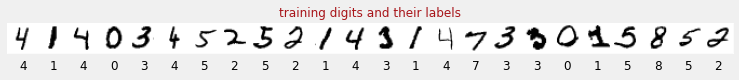

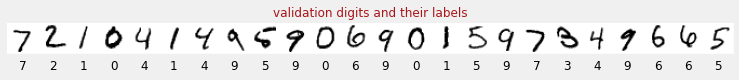

In [4]:
N = 24
(training_digits, training_labels,
 validation_digits, validation_labels) = dataset_to_numpy_util(training_dataset, validation_dataset, N)
display_digits(training_digits, training_labels, training_labels, "training digits and their labels", N)
display_digits(validation_digits[:N], validation_labels[:N], validation_labels[:N], "validation digits and their labels", N)
font_digits, font_labels = create_digits_from_local_fonts(N)

## Conv Net
Convolutional neural networks apply a series of learnable filters to the input image. A convolutional layer is defined by the filter (or kernel) size, the number of filters applied and the stride. In a layer of a convolutional network, one "neuron" does a weighted sum of the pixels just above it, across a small region of the image only. It adds a bias and feeds the sum through an activation function, just as a neuron in a regular dense layer would. This operation is then repeated across the entire image using the same weights.

The input and the output of a convolutional layer each have three dimensions (width, height, number of channels), starting with the input image (width, height, RGB channels).

When stacking convolutional layers, the width and height of the output can be adjusted by using a stride >1 or with a max-pooling operation. The depth of the output (number of channels) is adjusted by using more or fewer filters.


In regular dense layers, each neuron had its own weights. Here, a single "patch" of weights slides across the image in both directions


By performing the convolutions with a stride of 2 or 3, we can also shrink the resulting data cube in its horizontal dimensions. There are two common ways of doing this:

    - Strided convolution: a sliding filter as above but with a stride >1
    - Max pooling: a sliding window applying the MAX operation (typically on 2x2 patches, repeated every 2 pixels)

Sliding the computing window by 3 pixels results in fewer output values. Strided convolutions or max pooling (max on a 2x2 window sliding by a stride of 2) are a way of shrinking the data cube in the horizontal dimensions.


"Max-pooling" can help us understand intuitively how convolutional networks operate: if you assume that during training, the patches of weights evolve into filters that recognise basic shapes (horizontal and vertical lines, curves, ...), then one way of boiling useful information down is to keep through the layers the outputs where a shape was recognised with the maximum intensity. In practice, in a max-pool layer neuron outputs are processed in groups of 2x2 and only the max value is retained.


After the last convolutional layer, the data is in the form of a "cube". There are two ways of feeding it through the final dense layer.

The first one is to flatten the cube of data into a vector and then feed it to the softmax layer. Sometimes, you can even add a dense layer before the softmax layer. This tends to be expensive in terms of the number of weights. A dense layer at the end of a convolutional network can contain more than half the weights of the whole neural network.

Instead of using an expensive dense layer, we can also split the incoming data "cube" into as many parts as we have classes, average their values and feed these through a softmax activation function. This way of building the classification head costs 0 weights. In Keras, there is a layer for this: tf.keras.layers.GlobalAveragePooling2D(). Convolutional neural networks detect the location of things. When a filter responds strongly to some feature, it does so in a specific (x, y) location. Depending on what you want to do, a neural network can be trained to either use or discard this location data. Using global average pooling explicitly discards all location data. That might be fine for a flower classifier, but might not work well for other tasks, such as counting flowers in an image. Use with caution.


##Model building

In [5]:
#convolutional model
model = tf.keras.Sequential(
  [
      tf.keras.layers.Reshape(input_shape=(28*28,), target_shape=(28, 28, 1)),
      tf.keras.layers.Conv2D(kernel_size=3, filters=12, activation='relu', padding='same'),
      tf.keras.layers.Conv2D(kernel_size=6, filters=24, activation='relu', padding='same', strides=2),
      tf.keras.layers.Conv2D(kernel_size=6, filters=32, activation='relu', padding='same', strides=2),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(200, activation='relu'),
      tf.keras.layers.Dense(10, activation='softmax')
  ])

model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.01),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 28, 28, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 12)        120       
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 24)        10392     
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 32)          27680     
                                                                 
 flatten (Flatten)           (None, 1568)              0         
                                                                 
 dense (Dense)               (None, 200)               313800    
                                                                 
 dense_1 (Dense)             (None, 10)                2

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


## Learning Rate Scheduler

<ipython-input-2-aaa4f230fd33>:83: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  xx = np.arange(epochs+1, dtype=np.float)


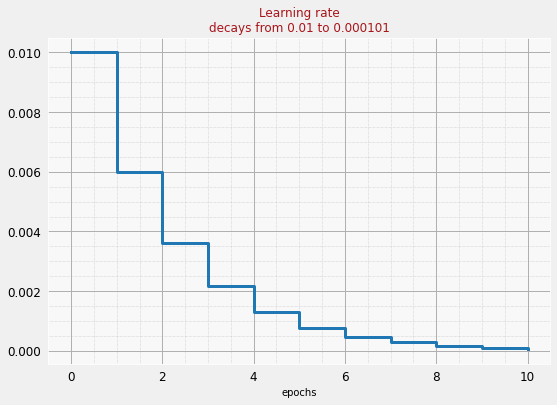

In [6]:
def lr_decay(epoch):
  return 0.01 * math.pow(0.6, epoch)

lr_decay_callback = tf.keras.callbacks.LearningRateScheduler(lr_decay, verbose=True)

plot_learning_rate(lr_decay, EPOCHS)

plot_training = PlotTraining(sample_rate=10, zoom=16)

##Train and validate model

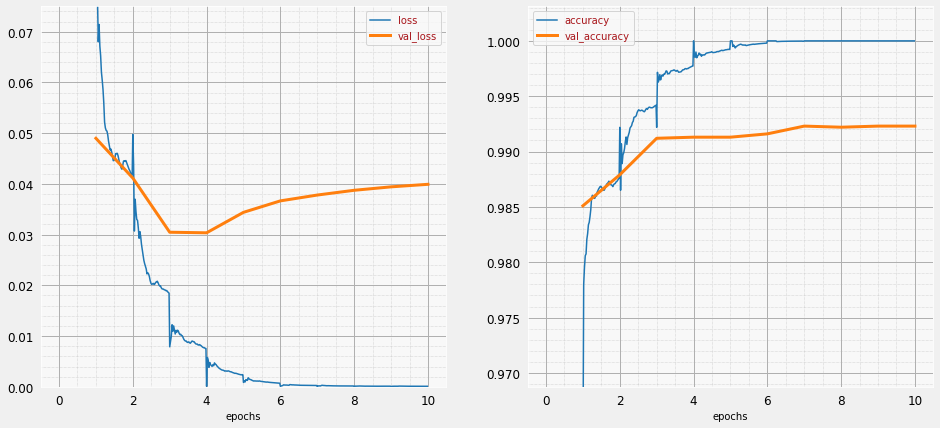

468/468 [==============================] - 77s 165ms/step - loss: 1.0326e-04 - accuracy: 1.0000 - val_loss: 0.0399 - val_accuracy: 0.9923 - lr: 1.0078e-04


In [7]:
steps_per_epoch = 60000//BATCH_SIZE
print("Steps per epoch: ", steps_per_epoch)
history = model.fit(training_dataset, steps_per_epoch=steps_per_epoch, epochs=EPOCHS,
                    validation_data=validation_dataset, validation_steps=1, callbacks=[plot_training,lr_decay_callback])
#Overfitting is clearly visible

##Visualize predictions

1/1 [==============================] - 0s 138ms/step


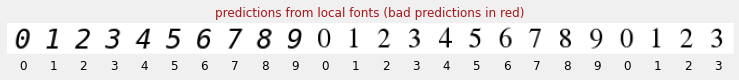

1/1 [==============================] - 3s 3s/step


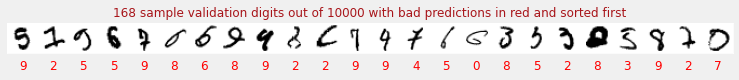

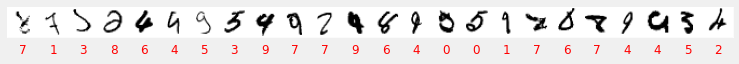

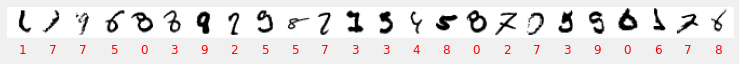

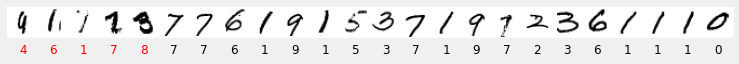

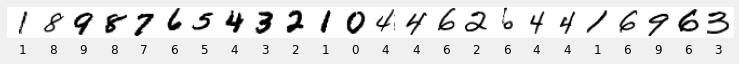

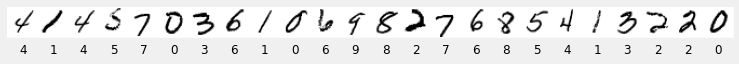

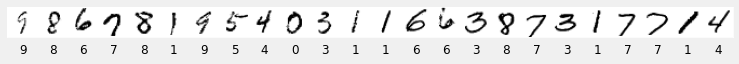

In [8]:
# recognize a set of printed digits rendered from local fonts
probabilities = model.predict(font_digits, steps=1)
predicted_labels = np.argmax(probabilities, axis=1) # find out which probability is the highest among a vector of 10 probabilities from its final "softmax" in my NN
display_digits(font_digits, predicted_labels, font_labels, "predictions from local fonts (bad predictions in red)", N)

# recognize validation digits
probabilities = model.predict(validation_digits, steps=1)
predicted_labels = np.argmax(probabilities, axis=1)
display_top_unrecognized(validation_digits, predicted_labels, validation_labels, N, 7)

In [9]:
# Adding dropout of 40%
model = tf.keras.Sequential(
  [
      tf.keras.layers.Reshape(input_shape=(28*28,), target_shape=(28, 28, 1)),
      tf.keras.layers.Conv2D(kernel_size=3, filters=12, activation='relu', padding='same'),
      tf.keras.layers.Conv2D(kernel_size=6, filters=24, activation='relu', padding='same', strides=2),
      tf.keras.layers.Conv2D(kernel_size=6, filters=32, activation='relu', padding='same', strides=2),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(200, activation='relu'),  
      tf.keras.layers.Dropout(0.4),
      tf.keras.layers.Dense(10, activation='softmax')
  ])

model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.01),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_1 (Reshape)         (None, 28, 28, 1)         0         
                                                                 
 conv2d_3 (Conv2D)           (None, 28, 28, 12)        120       
                                                                 
 conv2d_4 (Conv2D)           (None, 14, 14, 24)        10392     
                                                                 
 conv2d_5 (Conv2D)           (None, 7, 7, 32)          27680     
                                                                 
 flatten_1 (Flatten)         (None, 1568)              0         
                                                                 
 dense_2 (Dense)             (None, 200)               313800    
                                                                 
 dropout (Dropout)           (None, 200)              

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


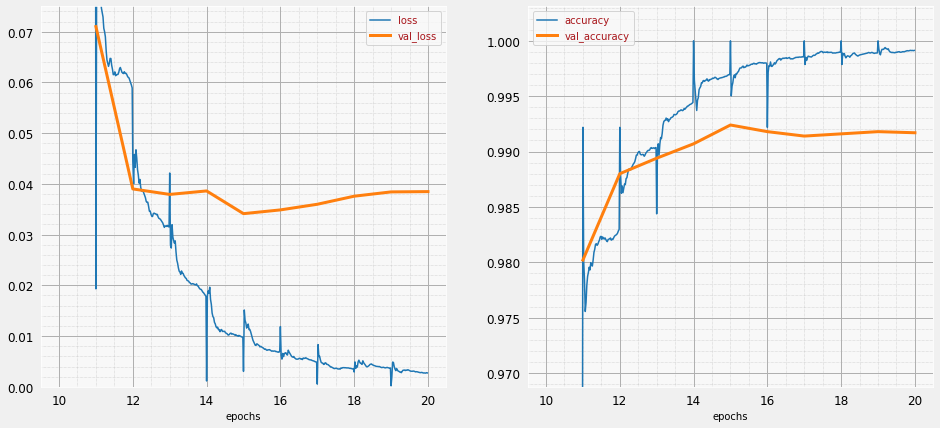

468/468 [==============================] - 75s 160ms/step - loss: 0.0028 - accuracy: 0.9991 - val_loss: 0.0385 - val_accuracy: 0.9917 - lr: 1.0078e-04


In [10]:
#Retraining
steps_per_epoch = 60000//BATCH_SIZE
print("Steps per epoch: ", steps_per_epoch)
history = model.fit(training_dataset, steps_per_epoch=steps_per_epoch, epochs=EPOCHS,
                    validation_data=validation_dataset, validation_steps=1, callbacks=[plot_training,lr_decay_callback])

##Batch Normalisation

Batch norm tries to address the problem of how neuron outputs are distributed relatively to the neuron's activation function

It normalizes neuron outputs across a training batch of data, i.e it subtracts the average and divides by the standard deviation. However, doing just that would be too brutal. With a perfectly centered and normally wide distribution everywhere, all neurons would have the same behavior. The trick is to introduce two additional learnable parameters per neuron, 𝛼 and 𝛽, and to compute:

𝛼 . normalized_out + 𝛽

And then apply the activation function (sigmoid, relu, ...). This way, the network decides, through machine learning, how much centering and re-scaling to apply at each neuron. 

In practice, 𝛼 and 𝛽 are not always both needed. In Keras, they are called "scale" and "center" and can selectively be used one or the other, for example:

tf.keras.layers.BatchNormalization(scale=False, center=True)

The problem with batch norm is that at prediction time, net does not have training batches over which it could compute the statistics of neuron outputs. But it still needs those values. During training, a "typical" neuron output average and standard deviation is computed across a "sufficient" number of batches, in practice using a running exponential average. These stats are then used at inference time.

In Keras on using tf.keras.layers.BatchNormalization layer all these accounting will happen automatically.

If center=True is used in batch norm, you do not need biases in your layer. The batch norm offset plays the role of a bias.
If you use an activation function that is scale-invariant (i.e. does not change shape if you zoom on it) then you can set scale=False. Relu is scale-invariant. Sigmoid is not.

By following some best practices of tweaking the batch size, learning rate, learning rate decay and dropout rate, batch norm can be effectively used and a handsome performance can be obtained. For example:

batch size 64
lr 0.666
dr 0.3


Batch norm helps neural networks converge and usually allows you to train faster.It is a regularizer. You can usually decrease the amount of dropout you use, or even not use dropout at all.


In [11]:
# Adding batch norm
model = tf.keras.Sequential(
  [
      tf.keras.layers.Reshape(input_shape=(28*28,), target_shape=(28, 28, 1)),
      
      tf.keras.layers.Conv2D(kernel_size=3, filters=12, use_bias=False, padding='same'),
      tf.keras.layers.BatchNormalization(center=True, scale=False),
      tf.keras.layers.Activation('relu'),
      
      tf.keras.layers.Conv2D(kernel_size=6, filters=24, use_bias=False, padding='same', strides=2),
      tf.keras.layers.BatchNormalization(center=True, scale=False),
      tf.keras.layers.Activation('relu'),
      
      tf.keras.layers.Conv2D(kernel_size=6, filters=32, use_bias=False, padding='same', strides=2),
      tf.keras.layers.BatchNormalization(center=True, scale=False),
      tf.keras.layers.Activation('relu'),
      
      tf.keras.layers.Flatten(),
      
      tf.keras.layers.Dense(200, use_bias=False),
      tf.keras.layers.BatchNormalization(center=True, scale=False),
      tf.keras.layers.Activation('relu'),
      
      tf.keras.layers.Dropout(0.3),
      tf.keras.layers.Dense(10, activation='softmax')
  ])

model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.01),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


model.summary()


plot_training = PlotTraining(sample_rate=10, zoom=16)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_2 (Reshape)         (None, 28, 28, 1)         0         
                                                                 
 conv2d_6 (Conv2D)           (None, 28, 28, 12)        108       
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 12)       36        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 28, 28, 12)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 14, 14, 24)        10368     
                                                                 
 batch_normalization_1 (Batc  (None, 14, 14, 24)       72        
 hNormalization)                                      

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


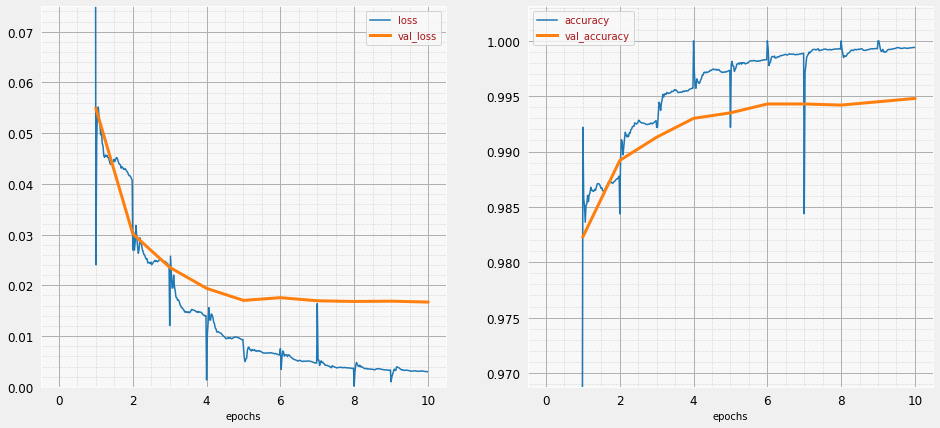

468/468 [==============================] - 91s 195ms/step - loss: 0.0030 - accuracy: 0.9994 - val_loss: 0.0167 - val_accuracy: 0.9948 - lr: 1.0078e-04


In [12]:
steps_per_epoch = 60000//BATCH_SIZE 
print("Steps per epoch: ", steps_per_epoch)

history = model.fit(training_dataset, steps_per_epoch=steps_per_epoch, epochs=EPOCHS,
                    validation_data=validation_dataset, validation_steps=1, callbacks=[plot_training, lr_decay_callback])